In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad
import numpy as np

In [2]:
df = pd.read_csv('dados_avc.csv')
df.head(2)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [3]:
# Preencher valores ausentes em 'bmi' com a média
df['bmi'].replace('N/A', float('nan'), inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

# Converter colunas categóricas usando one-hot encoding
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
df.head(2)


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.600000,1,True,False,True,False,True,False,False,True,True,False,False
1,51676,61.0,0,0,202.21,28.893237,1,False,False,True,False,False,True,False,False,False,True,False


In [4]:
X = df.drop(['stroke', 'id','age', 'bmi', 'avg_glucose_level'], axis=1)
Y = df['stroke']


In [5]:
X.head(1)

,hypertension,heart_disease,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1,True,False,True,False,True,False,False,True,True,False,False


In [6]:
## converting the 0 to -1
X = X.replace(0, -1)

## convering the True to 1 and False to -1
Y = Y.replace(0, -1)
X = X.replace(True, 1)
X = X.replace(False, -1)

X = X.astype('float64')
Y = Y.astype('float64')

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [8]:
def loss( parametros ):
    w, b, x, y = parametros
    est = w.T @ x + b
    mse = np_.mean( (est - y)**2)
    return mse

g = grad(loss)
x = np.array(X_train).T
y = np.array(Y_train)


In [9]:
w = np.random.randn(x.shape[0], 1)
b = 0.0
alpha = 10**-2

for n in range(15000):
    grad_ = g( (w, b, x, y) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]


In [10]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred)

In [11]:
def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))

## create tuples with value of w and X column name
w_tuples = []
w_lin_model = []
for i in range(len(w)):
    w_tuples.append((w[i][0], X.columns[i]))
    w_lin_model.append((model.coef_[i], X.columns[i]))

## sort the tuples
w_tuples.sort(reverse=True)
w_lin_model.sort(reverse=True)


In [12]:
print(w_tuples)

x = np.array(X_test).T
y = np.array(Y_test)

y_est = w.T @ x + b
print(f"Acurácia do modelo: {accuracy(y, y_est) * 100:.2f}%")

print(w_lin_model)

print(accuracy_score(Y_test, Y_pred))

[(0.5397924029485683, 'gender_Other'), (0.10403783735307674, 'heart_disease'), (0.06848126421796918, 'hypertension'), (0.0199146137780741, 'ever_married_Yes'), (0.009415695260193651, 'Residence_type_Urban'), (0.00904048503836839, 'work_type_Self-employed'), (0.007912840744473505, 'smoking_status_formerly smoked'), (0.005764533479476248, 'work_type_Never_worked'), (0.0031605298094929, 'work_type_Private'), (-0.0009663100478615236, 'smoking_status_smokes'), (-0.0030107389927552563, 'gender_Male'), (-0.005210247015975264, 'smoking_status_never smoked'), (-0.013697247967740007, 'work_type_children')]
Acurácia do modelo: 94.13%
[(0.10323045935489358, 'heart_disease'), (0.06803889521842481, 'hypertension'), (0.019298298933304286, 'ever_married_Yes'), (0.009476758984370287, 'Residence_type_Urban'), (0.007479924208770146, 'work_type_Self-employed'), (0.00701765851320971, 'smoking_status_formerly smoked'), (0.0016139347151004155, 'work_type_Private'), (-4.163336342344337e-17, 'gender_Other'), (

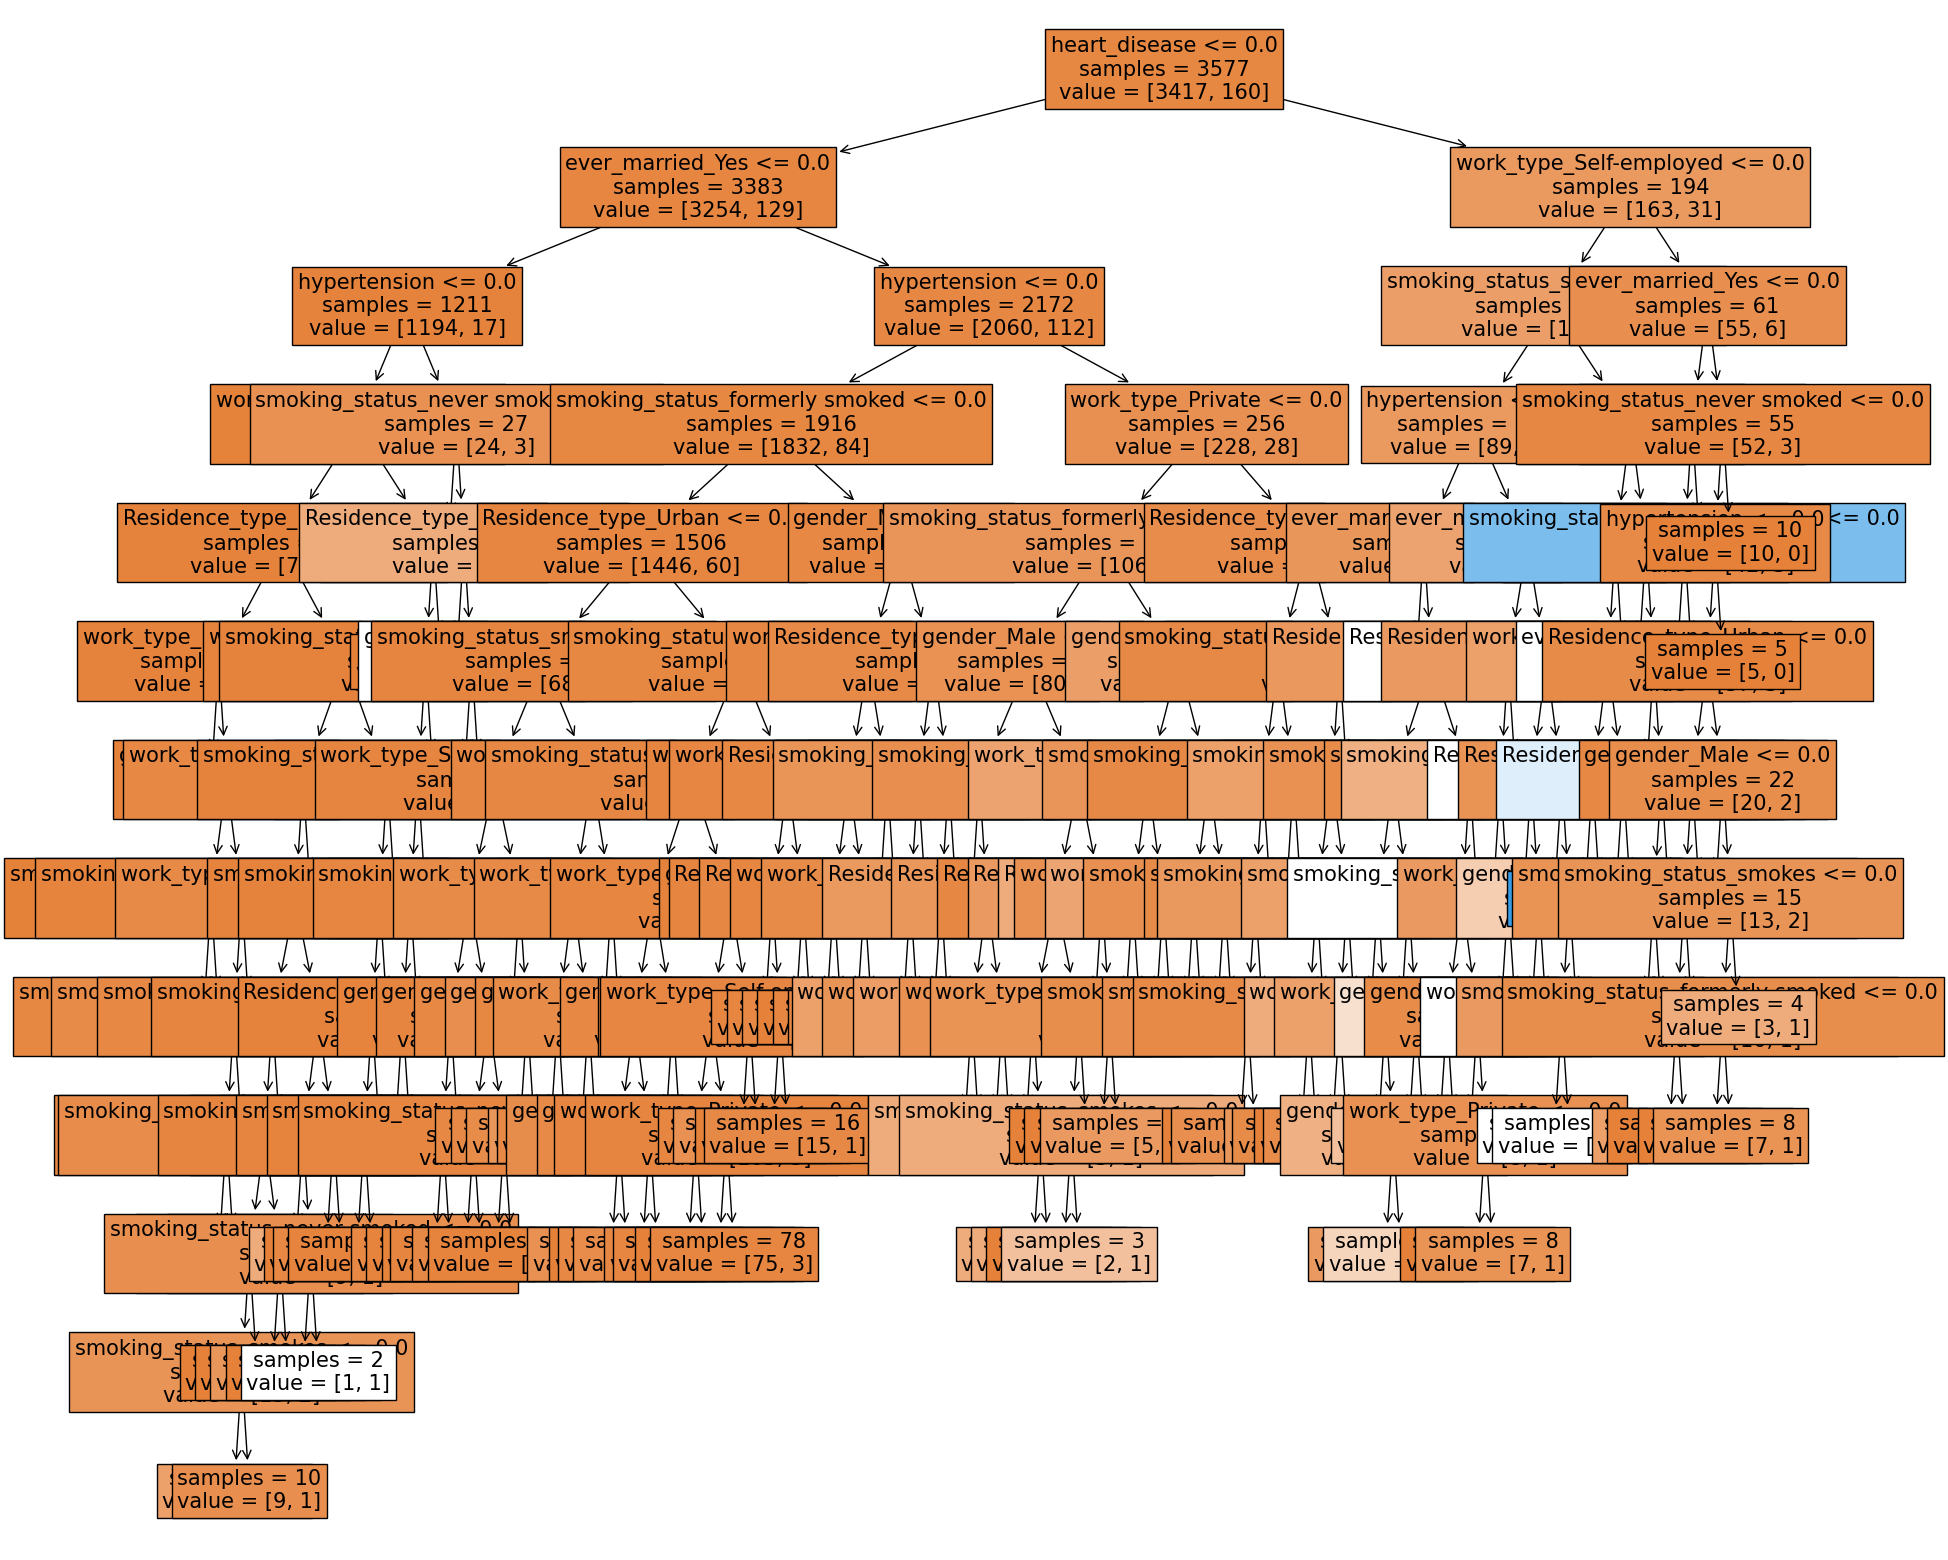

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy')

# Agora, vamos usar o método .fit() para ajustar os parâmetros da árvore:
tree.fit(X_train, Y_train)

# Podemos visualizar a árvore de decisão em uma figura!
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=X.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)

In [15]:
from sklearn.metrics import accuracy_score

y_pred = tree.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Acurácia do modelo de árvore de decisão:", accuracy)


Acurácia do modelo de árvore de decisão: 0.9419439008480104


In [16]:
import pandas as pd

# Obter importância das características
feature_importances = tree.feature_importances_

# Criar DataFrame com as features e sua importância
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Ordenar o DataFrame pela importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Exibir o DataFrame
print(feature_importance_df)


                           Feature  Importance
2                      gender_Male    0.158733
4                 ever_married_Yes    0.158399
1                    heart_disease    0.133388
11     smoking_status_never smoked    0.125574
10  smoking_status_formerly smoked    0.092348
9             Residence_type_Urban    0.091692
0                     hypertension    0.087839
6                work_type_Private    0.056378
7          work_type_Self-employed    0.039732
12           smoking_status_smokes    0.036993
8               work_type_children    0.013905
5           work_type_Never_worked    0.005019
3                     gender_Other    0.000000
